# Optimal Test Stopping

## Standard Setting

When we design an A/B test or, more generally, an experiment, the standard steps are the following

1. Define a **null hypothesis** $H_0$
    - usually the null is a zero effect of the experiment on a metric of interest

2. Define a **significance level** $\alpha$
    - usually equal to 0.05, it represents the maximum probability of rejecting the null hypothesis when it is true

3. Define an **alternative hypothesis** $H_1$
    - usually the minimum effect that we would like to detect
    
4. Define a **power level** $\beta$
    - usually equal to 0.8, it represents the minimum probability of rejecting the null hypothesis, when the alternative is true
   
5. Pick a **test statistic** whose distribution is known under both hypotheses
    - usually the sample average of a metric of interest
    
6. Compute the minimum **sample size** 
    - in order to achieve the desired power level, given all the test parameters
    
Then, we **run the test** and, depending on the realized value of the test statistic, we decide whether to **reject** the null hypothesis or not, depending on whether the p-value is lower than the significance level.

Rejecting the null hypothesis does not imply accepting the alternative hypothesis. 

## Peaking

Suppose that half-way through the experiment we were to **peak at the data**, and notice that the p-value is lower than the significant level. Should we stop the experiment? If we do, what happens?

The answer is that the test would not achieve the desired significance level or, in other terms, our confidence intervals would have the **wrong coverage**.

Let's see what I mean with a **example**. Suppose our **data generating process** is a standard normal distribution with zero mean and unit variance $X \sim N(0,1)$. 

Suppose that the variance is known while the mean is not. The **hypothesis** that we wish to test is

$$
\begin{align}
H_0: \quad & \mu = 0 ,
\newline
H_1: \quad & \mu = 0.1
\end{align}
$$

After each observation $n$, we compute the **test statistic** 

$$
t = \sqrt{n} \frac{\bar X - \mu}{\sigma}
$$ 

where $\bar X$ is the sample mean from a sample $X_1, X_2, ..., X_n$, of size $n$, $\sigma$ is the standard deviation of the population, and $\mu$ is the population mean. Under the null hypothesis of zero mean, the test statistic is distributed as a standard normal.

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from src.utils import *

In [3]:
tstat = lambda x: np.mean(x) * np.sqrt(len(x))

Suppose we want a test with significance level $\alpha=0.05$ and power $\beta=0.8$. What sample size do we need?

$$
N : \quad 0 + z_{0.95} * \frac{\sigma}{\sqrt{N}} = 0.1 - z_{0.8} * \frac{\sigma}{\sqrt{N}}
$$

so that

$$
N = \left( \frac{z_{0.95} + z_{0.8}}{0.1 * \sigma} \right)^2 
$$

where $z_{p}$ is the CDF inverse (or percent point function) at $p$.

In [4]:
from scipy.stats import norm

N = ( (norm.ppf(0.95) + norm.ppf(0.8)) / 0.1 )**2
print(f"Sample size: {N}")

Sample size: 618.2557232019765


We need at least $N=619$ observations.

In [5]:
def experiment(f_stat, mu=0, N=619, seed=1):
    np.random.seed(seed)
    n = np.arange(1, N+1)
    x = np.random.normal(mu, 1, N)
    stat = [f_stat(x[:i]) for i in n]
    df = pd.DataFrame({'n': n, 'x': x, 'stat': stat})
    return df

Let's have a look at what a sample looks like.

In [6]:
df = experiment(tstat)
df.head()

,n,x,stat
0,1,1.624345,1.624345
1,2,-0.611756,0.716009
2,3,-0.528172,0.279678
3,4,-1.072969,-0.294276
4,5,0.865408,0.123814


We can now plot the time trend of the test statistic over the sampling process. I also mark the likes at $-1.96$ and $1.96$ for statistical significance.

In [7]:
def plot_experiment(df, ybounds, **kwargs):
    sns.lineplot(data=df, x='n', y='stat', **kwargs)
    for ybound in ybounds:
        sns.lineplot(x=df['n'], y=ybound, lw=1, color='black')
    plt.title('T-statistic with sequential sampling')

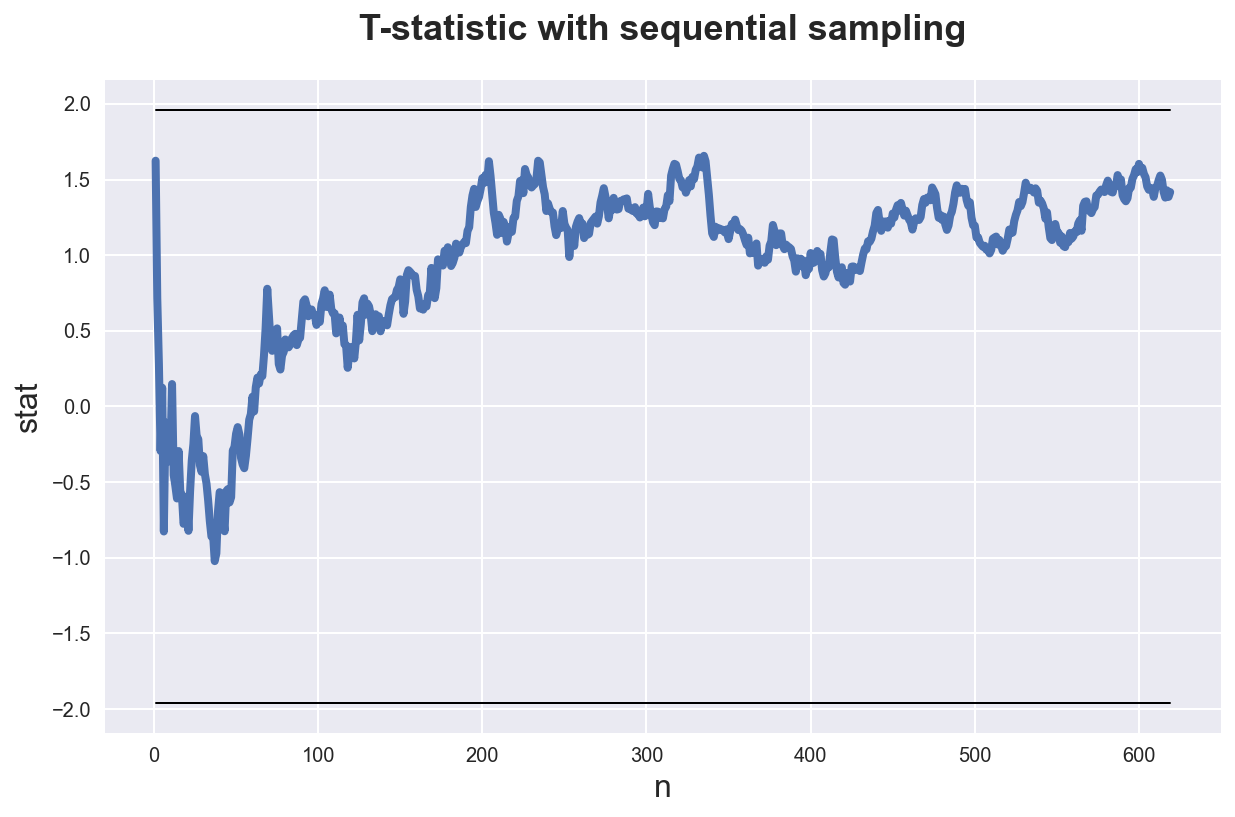

In [8]:
plot_experiment(df, ybounds=[-1.96, 1.96])

In this case, the test never achieves statistical significance. Therefore, peaking does not have an effect. We would not have stopped the experiment prematurely. 

What would happen if we were repeating the experiment many times? Let's simulate this procedure $K=100$ times.

In [9]:
def simulate_experiments(f_stat, ybounds, early_stop=False, mu=0, K=100, **kwargs):
    stops = np.zeros(K)
    for k in range(K):
        # Draw data
        df = experiment(f_stat, mu=mu, seed=k)
        vals = df['stat'].values[100:]
        
        # If early stop, plot violations
        if early_stop:
            violations = (vals > max(ybounds)) + (vals < min(ybounds))
        if early_stop and any(violations):
            end = 101+np.where(violations)[0][0]
            plot_experiment(df.iloc[100:end, :], ybounds, **kwargs)
            stops[k] = end * np.sign(df['stat'].values[end])
        
        # Otherwise, check last value
        elif (vals[-1] > max(ybounds)) or (vals[-1] < min(ybounds)):
            plot_experiment(df.iloc[100:, :], ybounds, **kwargs)
            stops[k] = len(df) * np.sign(vals[-1])
        
        # Plot all other observations
        else: 
            plot_experiment(df[df['n']>100], ybounds, color='grey', alpha=0.1, lw=1)
    plt.title(f"{sum(stops!=0)} significant results ({sum(stops>0)/sum(stops!=0)*100:.4}% up)");
    return stops

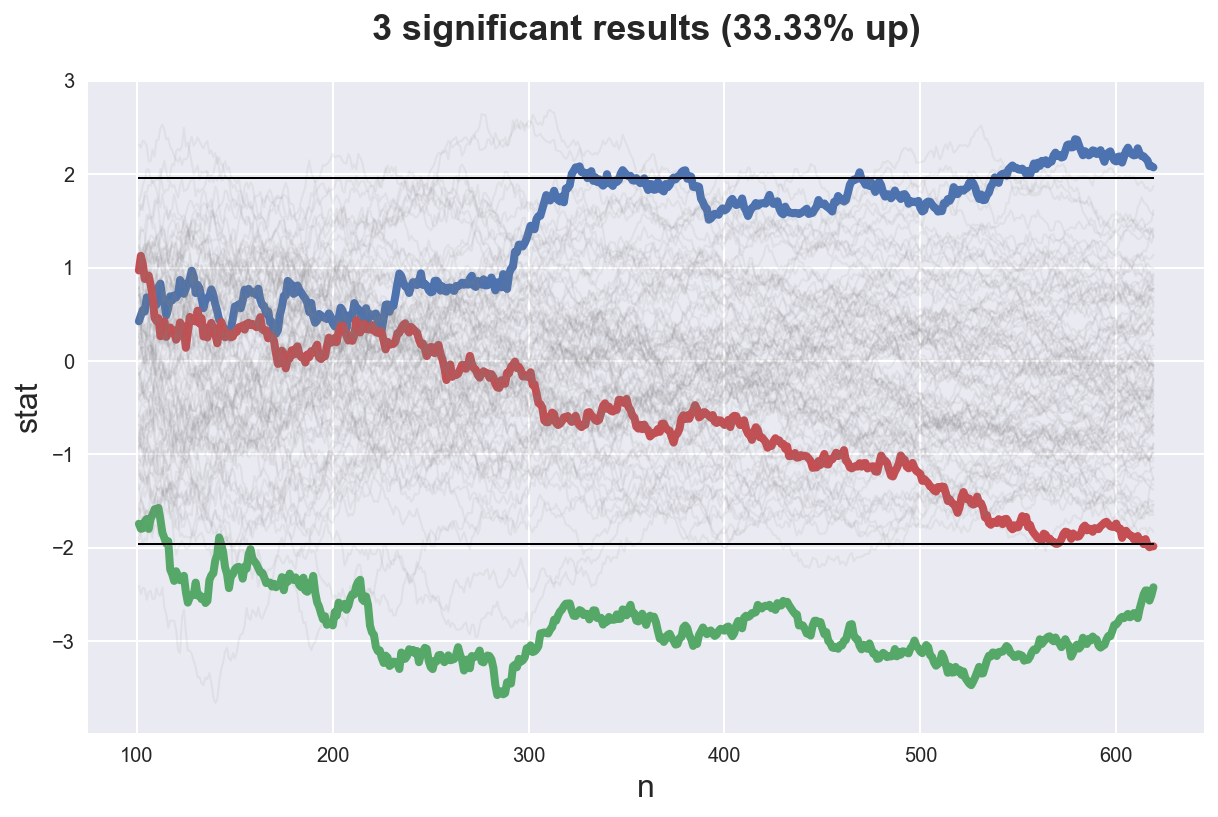

In [10]:
simulate_experiments(tstat, ybounds=[-1.96, 1.96], early_stop=False);

In the figure above, I have highlighted the experiments that would be statistically significant **without peaking**, i.e. given the value of the test statistic **at the end of the sampling** process. Only 3 simulations are statistically significant. This means a coverage of 97% which is very close to the expected coverage of 95%. 

What if instead we were stopping any time we were seeing a significant result?

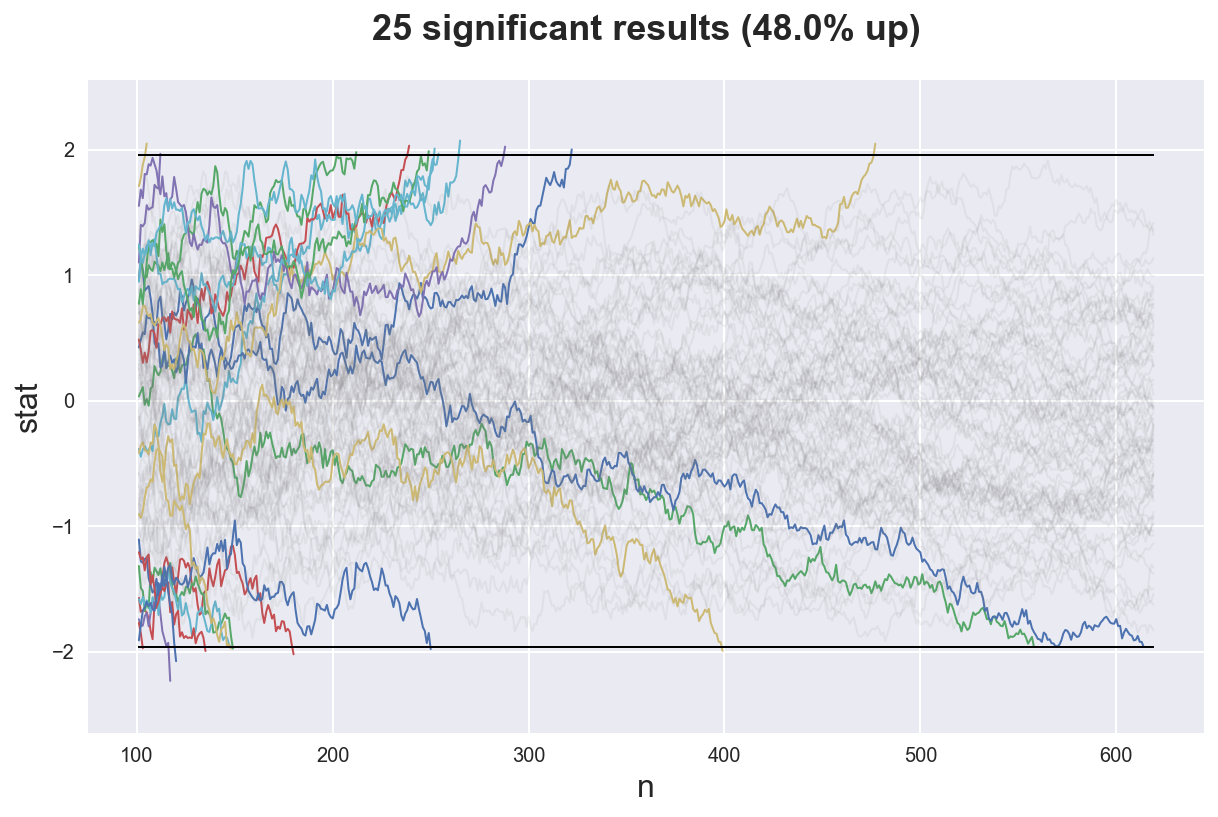

In [11]:
simulate_experiments(tstat, ybounds=[-1.96, 1.96], early_stop=True, lw=1);

In the figure above, I have highlighted the experiments that would be statistically significant **with constant peaking** from the 100th observation onwards. 25 simulations are statistically significant. This means a coverage of 75% which is very far from the expected coverage of 95%. Peaking distorts coverage of the confidence interval.

Potential solutions are:

1. **sequential probability ratio tests**
2. **sequential triangular testing**
3. **group sequential testing**

Before analyzing these sequential testing procedures, we first need to introduce the **likelihood ratio test**.

## Likelihood Ratio Test

A statistical test is fully specified when the distribution of the data is known under both the null and the alternative hypotheses. For example

$$
\begin{align}
H_0: \quad & \theta=\theta_0 ,
\newline
H_1: \quad & \theta=\theta_1 .
\end{align}
$$

If instead the alternative was more generally $H_1: \ \theta \neq \theta_0$, as common in hypothesis testing, we wouldn't know the distribution of the data under the alternative hypothesis. 

When a statistical test is fully specified, we can compute the likelihood ratio as the the ratio of the likelihood function under the two hypotheses.

$$
\Lambda (X) = \frac{\mathcal L (\theta_0 \ | \ X)}{\mathcal L (\theta_1 \ | \ X)}
$$

The likelihood-ratio test provides a decision rule as follows:

- If $\Lambda >c$, do not reject $H_{0}$;
- If $\Lambda <c$, reject $H_{0}$;
- If $\Lambda =c$, reject with probability $q$ 

The values $c$ and $q$ are usually chosen to obtain a specified significance level $\alpha$.

The **Neyman–Pearson lemma** states that this likelihood-ratio test is the most powerful among all level $\alpha$ tests for this case.

### Special Case: testing mean of normal distribution

Let's go back to our example where data is coming from a normal distribution with unknown mean $\mu$ and known variance $\sigma^2$ and we want to perform the following test

$$
\begin{align}
H_0: \quad & \mu = 0 ,
\newline
H_1: \quad & \mu = 0.1
\end{align}
$$

The likelihood of the normal distribution with unknown mean $\mu$ and known variance $\sigma^2$ is

$$
\mathcal L(\mu) = \left( \frac{1}{\sqrt{2 \pi} \sigma } \right)^n e^{- \sum_{i=1}^{n} \frac{(X_i - \mu)^2}{2 \sigma^2}}
$$

So that the likelihood ratio under the two hypotheses is

$$
\Lambda = \frac{\mathcal L (0, \sigma^2)}{\mathcal L (0.1, \sigma^2)} = \frac{e^{- \sum_{i=1}^{n} \frac{(X_i)^2}{2 \sigma^2}}}{e^{- \sum_{i=1}^{n} \frac{(X_i - 0.1)^2}{2 \sigma^2}}}
$$

## Sequential Probability Ratio Test

Given a pair of fully specified hypotheses, say $H_{0}$ and $H_{1}$, the **first step** of the sequential probability ratio test is to calculate the log likelihood ratio test $\log \Lambda_{i}$, as new data arrive: with $S_{0}=0$, then, for $i=1,2,...,$

$$
S_{n} = S_{n-1} + \log \Lambda_{n}
$$

The stopping rule is a simple thresholding scheme:

- $a<S_{i}<b$: continue monitoring (critical inequality)
- $S_{i}\geq b$: Accept $H_{1}$
- $S_{i}\leq a$: Accept $H_{0}$

where $a$ and $b$ ($a<0<b<\infty$) depend on the desired type I and type II errors, $\alpha$  and $\beta$. They may be chosen as follows:

$$
A \approx \log {\frac  {\beta }{1-\alpha }} \quad \text{and} \quad  B \approx \log {\frac  {1-\beta }{\alpha }}
$$

The equations are approximations because of the discrete nature of the data generating process.

### Special Case: testing null effect

Let's go back to our example where data is coming from a normal distribution with unknown mean $\mu$ and known variance $\sigma^2$ and hypotheses $H_0: \ \mu = 0$ and $H_1: \ \mu = 0.1$.

We have seen that the likelihood ratio with a sample of size $n$ is 

$$
\Lambda = \frac{\mathcal L (0, \sigma^2)}{\mathcal L (0.1, \sigma^2)} = \frac{e^{- \sum_{i=1}^{n} \frac{(X_i)^2}{2 \sigma^2}}}{e^{- \sum_{i=1}^{n} \frac{(X_i - 0.1)^2}{2 \sigma^2}}}
$$

Therefore, the log-likelihood is

$$
\log (\Lambda) = \left( \sum_{i=1}^{n} \frac{(X_i - 0.1)^2}{2 \sigma^2} \right) - \left( \sum_{i=1}^{n} \frac{(X_i)^2}{2 \sigma^2} \right)
$$

### Simulation

We are now ready to perform some simulations. First, let's code the **log likelihood ratio test statistic**.

In [12]:
log_lr = lambda x: (np.sum((x)**2) - np.sum((x - 0.1)**2) ) / 2

We now repeat the same experiment we did at the beginning, with one difference: we will compute the log likelihood ratio as a statistic. The data generating process has $\mu=0$, as under the null hypothesis.

In [13]:
df = experiment(log_lr)
df.head()

,n,x,stat
0,1,1.624345,0.157435
1,2,-0.611756,0.091259
2,3,-0.528172,0.033442
3,4,-1.072969,-0.078855
4,5,0.865408,0.002686


Let's now compute the optimal bounds, given significance level $\alpha=0.05$ and power $\beta=0.8$. 

In [14]:
A = np.log(0.8 / 0.05)
B = np.log(0.95 / 0.2)
print(f'Optimal bounds : [{A}, {B}]')

Optimal bounds : [2.772588722239781, 1.5581446180465497]


Since significance and (one minus) power are different, the bound for the null hypothesis is much wider than the bound for the alternative hypothesis. This means that, in case of a true effect of $\mu=0.05$, we will be more likely to accept the null hypothesis $H_0: \mu = 0$ than the alternative $H_1: \mu = 1$.

We can plot the distribution of the likelihood ratio over samples drawn under the null hypothesis $H_0: \mu = 0$.

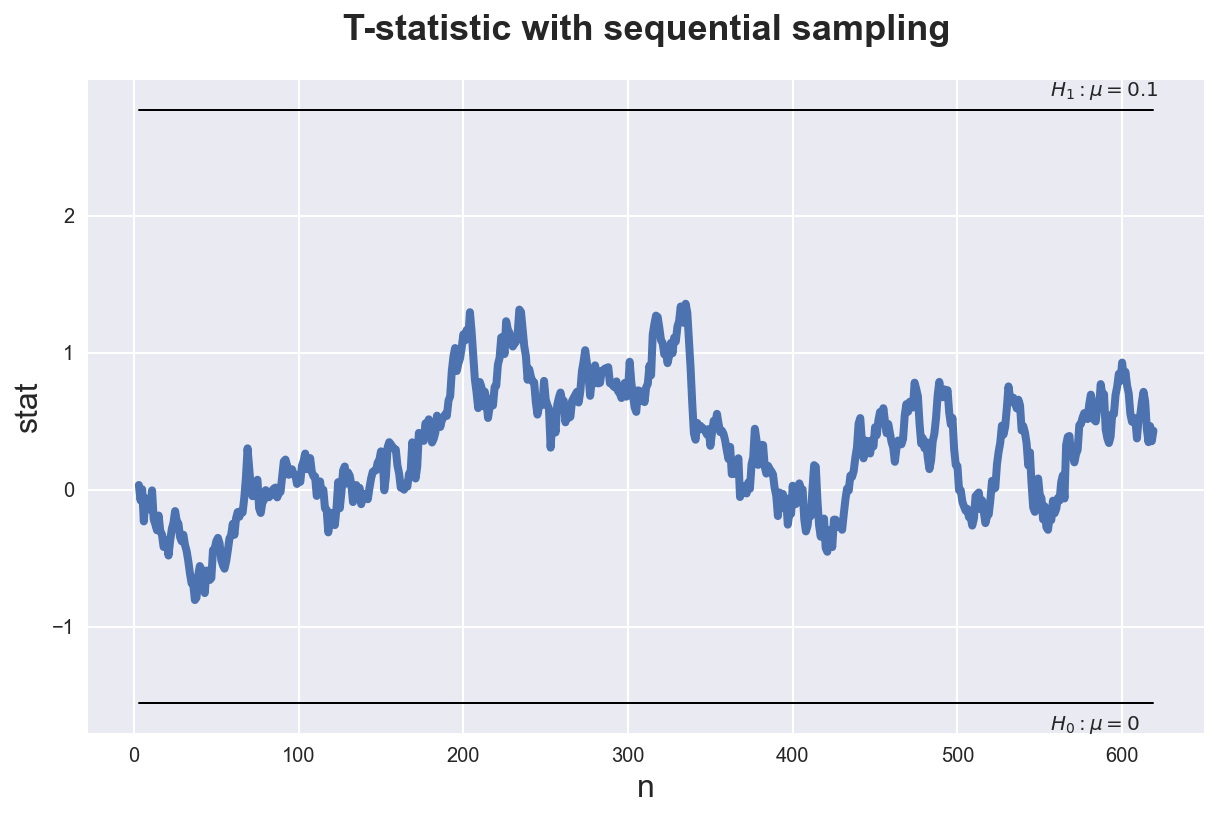

In [15]:
plot_experiment(df[2:], ybounds=[A,-B])
plt.annotate('$H_1: \mu = 0.1$', xy=(0.9*N, A+0.1));
plt.annotate('$H_0: \mu = 0$', xy=(0.9*N, -B-0.2));

In this particular case, the test is inconclusive within our sampling framework. We need to **collect more data** in order to come to a decision.

What would happen if we were to run the test $K=100$ times?

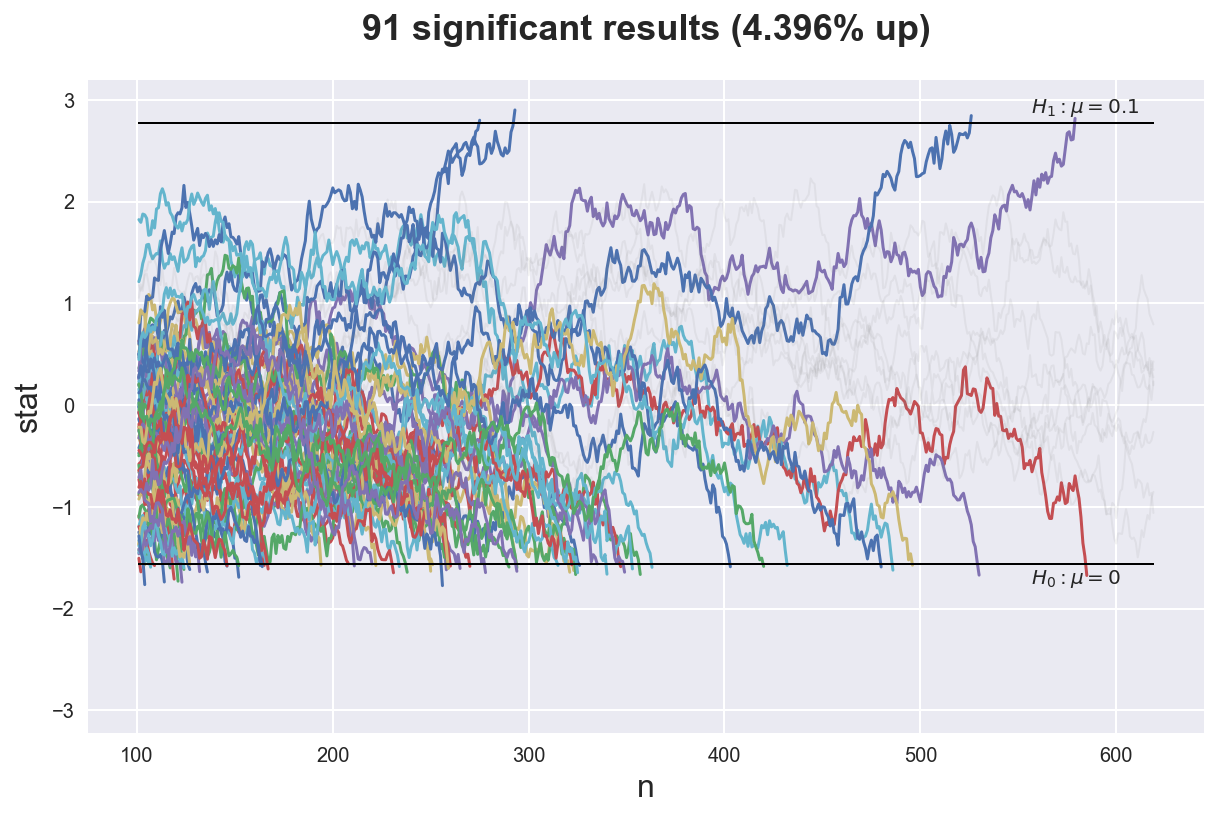

In [16]:
stops1 = simulate_experiments(log_lr, ybounds=[-B,A], early_stop=True, lw=1.5)
plt.annotate('$H_1: \mu = 0.1$', xy=(0.9*N, A+0.1));
plt.annotate('$H_0: \mu = 0$', xy=(0.9*N, -B-0.2));

We get a decision for 91 simulations out of 100 and for 87 of them, it's the correct decision. Therefore, our test coverage is 96%, very close to the desired 95%.

However, the biggest advantage now is that the average **sample size is much smaller**.

In [17]:
duration = (np.sum(np.abs(stops1)) + N*(100-sum(stops1!=0))) / len(stops1)
print(f'Average experiment duration: {duration}')

Average experiment duration: 266.1430150881779


To reach a conclusion in 90/100 experiments we need just 1/4 of the samples!

What would happen if instead the alternative hypothesis $H_1: \mu = 0.1$ was true?

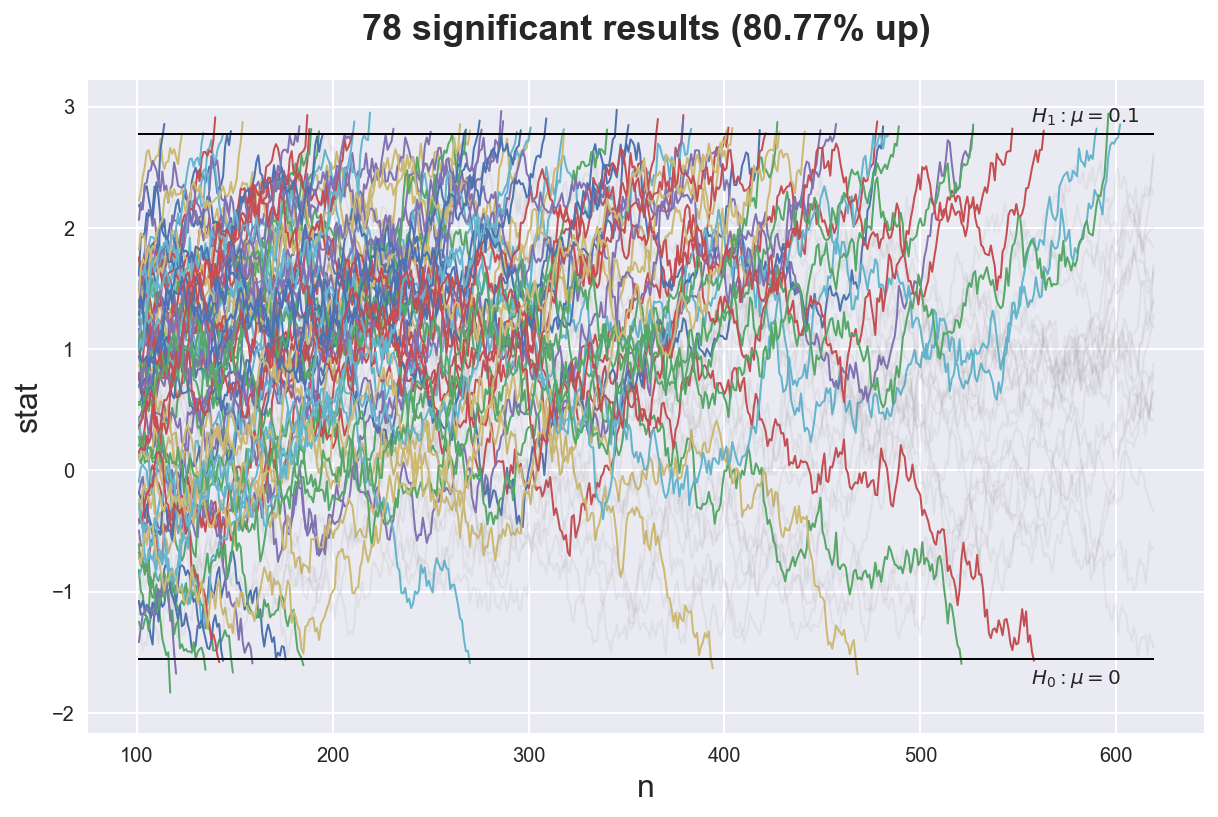

In [18]:
stops2 = simulate_experiments(log_lr, ybounds=[-B,A], early_stop=True, mu=0.1, lw=1)
plt.annotate('$H_1: \mu = 0.1$', xy=(0.9*N, A+0.1));
plt.annotate('$H_0: \mu = 0$', xy=(0.9*N, -B-0.2));

In this case, we make the correct decision only 81% of the times, as expected since the power of the test was 80%. 

Also in this case, we have significant savings in terms of average sample size.

In [19]:
duration = (np.sum(np.abs(stops2)) + N*(100-sum(stops2!=0))) / len(stops2)
print(f'Average experiment duration: {duration:0}')

Average experiment duration: 377.71625910443487


To reach a conclusion in 78/100 experiments we need just 1/3 of the samples!

## References

- [Lecture Notes](http://people.missouristate.edu/songfengzheng/Teaching/MTH541/Lecture%20notes/LRT.pdf) on Likelihood Ratio Tests
- [Improving Experimentation Efficiency](https://medium.com/netflix-techblog/improving-experimentation-efficiency-at-netflix-with-meta-analysis-and-optimal-stopping-d8ec290ae5be) by Netflix on Medium
- [Likelihood-ratio test](https://en.wikipedia.org/wiki/Likelihood-ratio_test) Wikipedia article
- [Sequential probability ratio test](https://en.wikipedia.org/wiki/Sequential_probability_ratio_test) Wikipedia article